# DATA 320

| Key | Value |
| :------- | :------ |
| Assignment | W6 - Practicdal Dashboards |
| Author | Sara Hodder |
| Date | 11-05-2025 |

In [4]:
# Installations
!pip install pymongo
!pip install certifi
!pip install pandas
!pip install regex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 19.5 MB/s eta 0:00:00


In [14]:
# Imports
import pandas as pd
import re
import pymongo
import certifi
import numpy as np
import statsmodels.formula.api
from matplotlib import pyplot as plt
from matplotlib import dates
import seaborn as sns
from datetime import datetime

In [13]:
# Connect to the database using known good certificates
client = pymongo.MongoClient(mongo_connection_string, tlsCAFile=certifi.where())
print(f"Using MongoDB version {client.server_info()['version']}.")

# Check what databases exist on this server
all_databases = client.list_database_names()
print(f"This MongoDB server has the databases {all_databases}")

# If we know the correct database to talk to, we connect like this:
my_database = client['MovieDatasets']

# Here is the list of collections within my database
all_collections = my_database.list_collection_names()
print(f"This database has the collections {all_collections}")

Using MongoDB version 8.0.16.
This MongoDB server has the databases ['MovieDatasets', 'admin', 'local']
This database has the collections ['Metacritic', 'IMDB', 'IMDB_Pipeline_View']


In [6]:
pipeline = [
    {
        '$addFields': {
            'gross_sales': '$gross_sales',
            'is_gross_sales_usd': {
                '$regexMatch': {
                    'input': '$gross_sales',
                    'regex': re.compile(r"^\\$")
                }
            },
            'gross_sales_value': {
                '$regexFind': {
                    'input': '$gross_sales',
                    'regex': re.compile(r"([\\d,]+)")
                }
            }
        }
    }, {
        '$addFields': {
            'gross_sales': '$gross_sales',
            'gross_sales_usd': {
                '$switch': {
                    'branches': [
                        {
                            'case': '$is_gross_sales_usd',
                            'then': {
                                '$toDecimal': {
                                    '$replaceAll': {
                                        'input': '$gross_sales_value.match',
                                        'find': ',',
                                        'replacement': ''
                                    }
                                }
                            }
                        }
                    ],
                    'default': None
                }
            }
        }
    }, {
        '$addFields': {
            'raw_mpaa': '$certification',
            'mpaa': {
                '$first': {
                    '$setIntersection': [
                        [
                            'G', 'PG', 'PG-13', 'R', 'NC-17'
                        ], {
                            '$split': [
                                '$certification', ', '
                            ]
                        }
                    ]
                }
            }
        }
    }, {
        '$addFields': {
            'release_year': {
                '$year': '$release_date'
            },
            'release_month': {
                '$month': '$release_date'
            }
        }
    }, {
        '$addFields': {
            'total_budget': '$budget',
            'is_budget_usd': {
                '$regexMatch': {
                    'input': '$budget',
                    'regex': re.compile(r"^\\$")
                }
            },
            'budget_value': {
                '$regexFind': {
                    'input': '$budget',
                    'regex': re.compile(r"([\\d,]+)")
                }
            }
        }
    }, {
        '$addFields': {
            'total_budget': '$budget',
            'budget_usd': {
                '$switch': {
                    'branches': [
                        {
                            'case': '$is_budget_usd',
                            'then': {
                                '$toDecimal': {
                                    '$replaceAll': {
                                        'input': '$budget_value.match',
                                        'find': ',',
                                        'replacement': ''
                                    }
                                }
                            }
                        }
                    ],
                    'default': None
                }
            }
        }
    }, {
        '$addFields': {
            'raw_opening_weekend': '$opening_weekend',
            'opening_weekend_sales': {
                '$first': {
                    '$split': [
                        '$opening_weekend', ', '
                    ]
                }
            }
        }
    }, {
        '$addFields': {
            'opening_weekend_sales': '$opening_weekend_sales',
            'is_opening_weekend_sales_usd': {
                '$regexMatch': {
                    'input': '$opening_weekend_sales',
                    'regex': re.compile(r"^\\$")
                }
            },
            'opening_weekend_sales_value': {
                '$regexFind': {
                    'input': '$opening_weekend_sales',
                    'regex': re.compile(r"([\\d,]+)")
                }
            }
        }
    }, {
        '$addFields': {
            'opening_weekend_sales': '$opening_weekend_sales',
            'opening_weekend_sales_usd': {
                '$switch': {
                    'branches': [
                        {
                            'case': '$is_opening_weekend_sales_usd',
                            'then': {
                                '$toDecimal': {
                                    '$replaceAll': {
                                        'input': '$opening_weekend_sales_value.match',
                                        'find': ',',
                                        'replacement': ''
                                    }
                                }
                            }
                        }
                    ],
                    'default': None
                }
            }
        }
    }, {
        '$addFields': {
            'user_rating': {
                '$toDecimal': '$user_rating'
            }
        }
    }
]

In [23]:
pipeline_2 = [
    {
        '$match': {
            'release_year': 1979,
            'mpaa': {'$exists': True, '$ne': ""}
        }
    },
    {
        '$group': {
            '_id': '$mpaa',
            'count': {'$sum': 1}
        }
    },
    {
        '$sort': {'count': -1}
    }
]

In [44]:
# Specify the name of the collection you want to load
collection_name = 'IMDB_Pipeline_View'

# Access the collection from the database
my_collection = my_database[collection_name]

# Query all documents in the collection
cursor = my_collection.find({})

# Convert the cursor to a pandas DataFrame
collection_df = pd.DataFrame(list(cursor))

# Display the first few rows of the DataFrame
# print(f"First 5 rows of the '{collection_name}' DataFrame:")
# display(collection_df.head())

# Display the columns of the DataFrame
# print(f"\nColumns in the '{collection_name}' DataFrame:")
# print(collection_df.columns)

In [45]:
# Convert IMDB view to numbers
collection_df.opening_weekend_sales_usd = pd.to_numeric(collection_df.opening_weekend_sales_usd.astype(str), errors='coerce')
collection_df.budget_usd = pd.to_numeric(collection_df.budget_usd.astype(str), errors='coerce')
collection_df.user_rating = pd.to_numeric(collection_df.user_rating.astype(str), errors='coerce')
collection_df.gross_sales_usd = pd.to_numeric(collection_df.gross_sales_usd.astype(str), errors='coerce')
collection_df.votes = pd.to_numeric(collection_df.votes.astype(str), errors='coerce')

In [46]:
# A custom formatter for currency
def format_currency(amount, _):
    if amount > 1_000_000_000_000:
        return f"${round(amount / 1_000_000_000_000)}T"
    elif amount > 1_000_000_000:
        return f"${round(amount / 1_000_000_000)}B"
    elif amount > 1_000_000:
        return f"${round(amount / 1_000_000)}M"
    elif amount > 1_000:
        return f"${round(amount / 1_000)}K"
    else:
        return f"${round(amount)}"

    # Add to charts using currency
    # plt.gca().yaxis.set_major_formatter(format_currency)

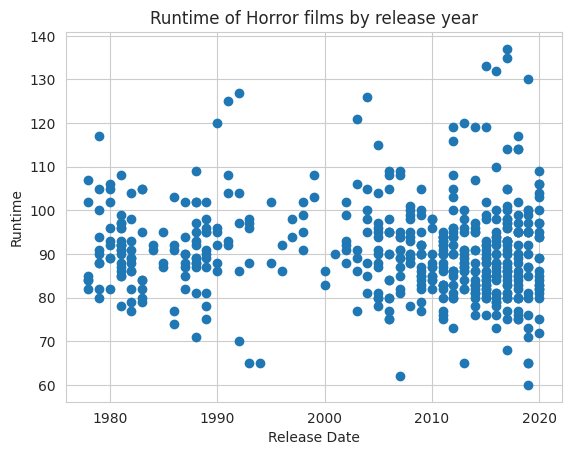

In [47]:
# Query the view to find horror films
cursor = my_collection.find({"genres": {"$in": ["Horror"]}})
horror_films = pd.DataFrame(list(cursor))

# Plot release date by runtime
plt.title('Runtime of Horror films by release year')
plt.scatter(horror_films['release_year'], horror_films['runtime'])
plt.xlabel('Release Date')
plt.ylabel('Runtime')
plt.show()

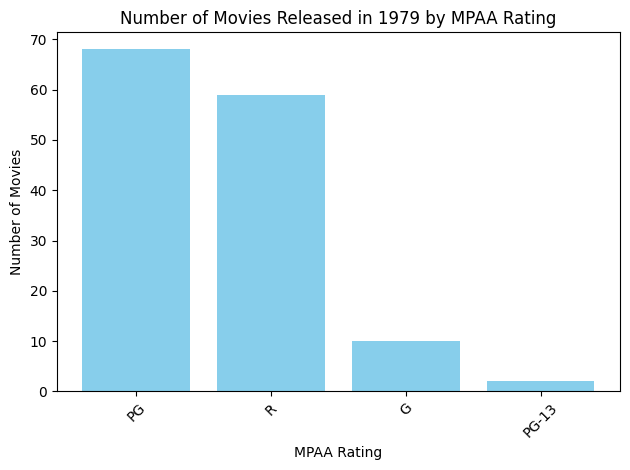

In [24]:
# Execute the aggregation query
mpaa_ratings = list(my_database['IMDB_Pipeline_View'].aggregate(pipeline_2))

ratings = [doc['_id'] for doc in mpaa_ratings]
counts = [doc['count'] for doc in mpaa_ratings]

plt.bar(ratings, counts, color='skyblue')
plt.xlabel("MPAA Rating")
plt.ylabel("Number of Movies")
plt.title("Number of Movies Released in 1979 by MPAA Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

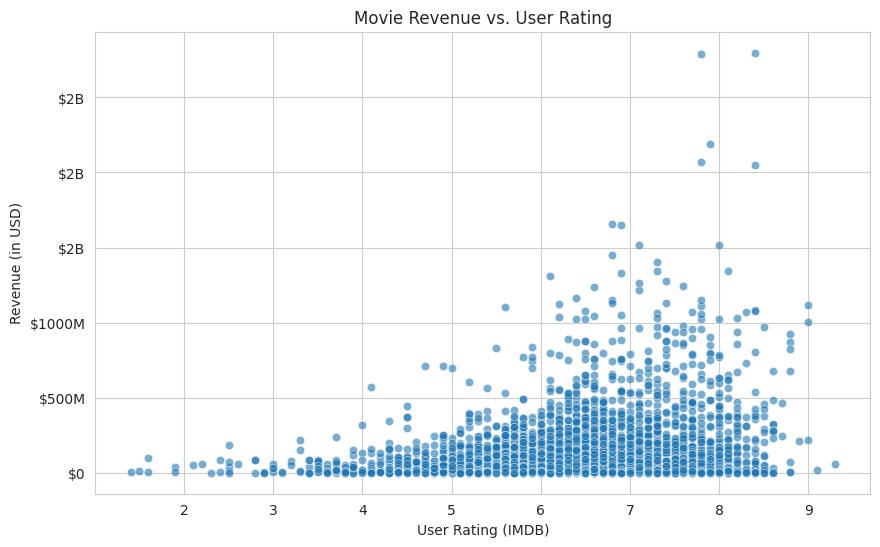

Correlation between Revenue and Rating: 0.18


In [49]:
# Specify the database and collection
db = client['MovieDatasets'] # Replace with your database name if different
collection = db['IMDB_Pipeline_View'] # Replace with your collection name if different

# Query for movies with both revenue (assuming 'boxOffice.revenue' field) and imdb.rating data
# The exact field names might vary in your dataset
query = {"gross_sales_usd": {"$exists": True, "$ne": None}, "user_rating": {"$exists": True, "$ne": None}}
projection = {"gross_sales_usd": 1, "user_rating": 1, "title": 1, "_id": 0}

# Fetch data and convert to a pandas DataFrame
# Using the list conversion method for clarity
cursor = collection.find(query, projection)
movies_df = pd.DataFrame(list(cursor))

# Convert 'gross_sales_usd' and 'user_rating' from Decimal128 to float
movies_df['gross_sales_usd'] = movies_df['gross_sales_usd'].apply(
    lambda x: float(str(x)) if x is not None else None
)
movies_df['user_rating'] = movies_df['user_rating'].apply(
    lambda x: float(str(x)) if x is not None else None
)

# Drop any potential remaining NaNs in the relevant columns
movies_df.dropna(subset=['gross_sales_usd', 'user_rating'], inplace=True)

# Set plot style
sns.set_style("whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_df, x='user_rating', y='gross_sales_usd', alpha=0.6)

# Add title and labels
plt.title('Movie Revenue vs. User Rating')
plt.xlabel('User Rating (IMDB)')
plt.ylabel('Revenue (in USD)')
plt.gca().yaxis.set_major_formatter(format_currency)
plt.show()

correlation = movies_df['gross_sales_usd'].corr(movies_df['user_rating'])
print(f"Correlation between Revenue and Rating: {correlation:.2f}")

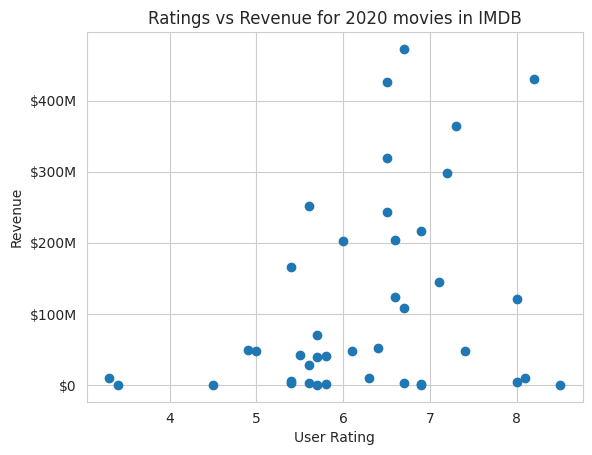

In [54]:
# Filter to a specific year and create a copy to avoid SettingWithCopyWarning
selected_films = collection_df[collection_df['release_year'] == 2020].copy()

# Convert 'gross_sales_usd' and 'user_rating' from Decimal128 to float
selected_films['gross_sales_usd'] = selected_films['gross_sales_usd'].apply(
    lambda x: float(str(x)) if x is not None else None
)
selected_films['user_rating'] = selected_films['user_rating'].apply(
    lambda x: float(str(x)) if x is not None else None
)

# Drop any NaNs that might result from conversion errors for these columns
selected_films.dropna(subset=['user_rating', 'gross_sales_usd'], inplace=True)

# Plot revenue by user rating
plt.title('Ratings vs Revenue for 2020 movies in IMDB')
plt.scatter(selected_films['user_rating'], selected_films['gross_sales_usd'])
plt.xlabel('User Rating')
plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(format_currency)
plt.show()

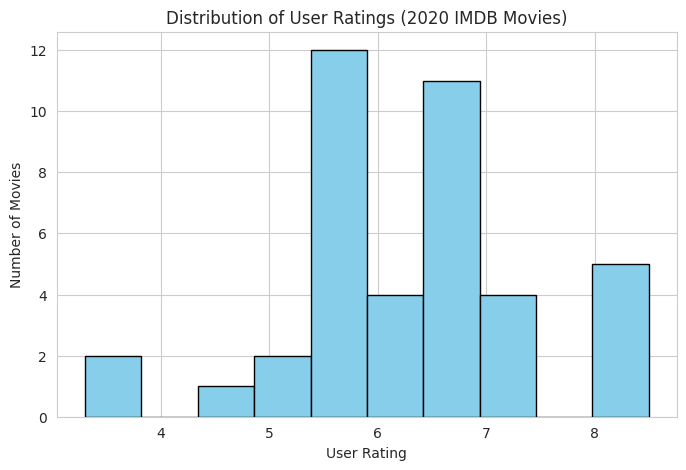

In [55]:
# Filter to a specific year and create a copy to avoid SettingWithCopyWarning
selected_films = collection_df[collection_df['release_year'] == 2020].copy()

# Convert 'gross_sales_usd' and 'user_rating' from Decimal128 to float
selected_films['gross_sales_usd'] = selected_films['gross_sales_usd'].apply(
    lambda x: float(str(x)) if x is not None else None
)
selected_films['user_rating'] = selected_films['user_rating'].apply(
    lambda x: float(str(x)) if x is not None else None
)

# Drop any NaNs that might result from conversion errors for these columns
selected_films.dropna(subset=['user_rating', 'gross_sales_usd'], inplace=True)

plt.figure(figsize=(8, 5))
plt.hist(selected_films['user_rating'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of User Ratings (2020 IMDB Movies)')
plt.xlabel('User Rating')
plt.ylabel('Number of Movies')
plt.show()